# 3 ML Model Predictions

# Imports & Functions

## Imports

In [2]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import joblib
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from ml_utilities import ml_model_pipeline_details, grid_search_results, classification_metrics, feature_importance

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Run. 1 Study Load & Model

In [4]:
#---- Parameters --------------------------------
# Study & Processing Run Details
# study_name = 'IOWA_Rest'
# eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'
# study_name = 'IOWA_Simon'
# eeg_features_run = '1b_EEG_Features_Results_Run_20250726_full_run'
study_name = 'UNM_Oddball'
eeg_features_run = '1b_EEG_Features_Results_Run_20250726_full_run'

ml_training_run = '2_Feature_Selection_Training_Run_20250803_select_train_regions_aperiodic'

run_description = 'predictions_model_channel_ap'
# test_mode = True
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')
 
# Feature Selection, Preparation and ML Model
models_folder_path = utils.get_folder_path('Saved_Models')
ml_training_run_results_path = utils.get_folder_path(models_folder_path + '/' + ml_training_run)
ml_training_run_details = pd.read_pickle(ml_training_run_results_path + '/run_details.pkl', compression='zip')

# Load Pipelines & Models
features_prep_pipeline = pickle.load(open(ml_training_run_results_path + '/' + 'features_prep_pipeline.pkl', 'rb'))
# TODO: Load all model files into a list
grid_search = pickle.load(open(ml_training_run_results_path + '/' + 'grid_search_randforest.pkl', 'rb'))
model_randforest = pickle.load(open(ml_training_run_results_path + '/' + 'model_randforest.pkl', 'rb'))



In [5]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Extraction / ML Training Run: {ml_training_run}"
summary = summary + f"\n-   Feature Extraction Params: {ml_training_run_details['extraction_params']}"
print(f'{summary}\n')


EEG Processing Parameters
- Study: UNM_Oddball ds003490-1.1.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250726_full_run
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250726_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
- Features Extraction / ML Training Run: 2_Feature_Selection_Training_Run_20250803_select_train_regions_aperiodic
-   Feature Extraction Params: {'features_detail_level': 'region', 'subject_meta_include': False, 'aperiodic_include': True, 'periodic_include': False}



# Run 2. Features Prep & Model Predictions

## Study Inspection

In [4]:
# TODO: Add summary infor on the study

## Features Selection & Prep

In [6]:
# Apply the features pipeline
#

print("Feature Extraction Pipeline Steps:")
for name, step in features_prep_pipeline.named_steps.items():
    print(f"- {name}: {step}")

print("\nColumnTransformer Details:")
ct = features_prep_pipeline.named_steps['data_preprocess']
for name, trans, cols in ct.transformers_:
    print(f"- Transformer: {name}")
    print(f"    Columns: {cols}")
    print(f"    Transformer object: {trans}\n")

# Apply to the features superset
target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()

X_transformed = features_prep_pipeline.transform(X)

# Before & After Datasets
print("Features Extraction vs Transformed Data Shapes")
print(f'- Original Features Selection: {eeg_features_flattened_df.shape}')
print(f'- Original X: {X.shape} and y: {y.shape}')
print(f'- Transformed X: {X_transformed.shape}')

# Check the pipeline structure
print("\nTransformed Features:")
cols_transform = features_prep_pipeline.named_steps['data_preprocess']
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")

feature_names = features_prep_pipeline.named_steps['data_preprocess'].get_feature_names_out()
print(f'Feature Names: {len(feature_names)}')
# print(feature_names)
temp_names_X_train_df = pd.DataFrame(X_transformed, columns=feature_names)
temp_names_X_train_df.reset_index(drop=True, inplace=True)
print(temp_names_X_train_df.shape)
display(temp_names_X_train_df.head())

Feature Extraction Pipeline Steps:
- features_selection: FeatureSelection(features_detail_level='region',
                 selected_features=['offset', 'exponent'])
- data_preprocess: ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scale_num',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17bad0290>),
                                ('categorical',
                                 Pipeline(steps=[('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
   

,numeric__region_frontal_offset,numeric__region_frontal_exponent,numeric__region_central_offset,numeric__region_central_exponent,numeric__region_posterior_offset,numeric__region_posterior_exponent
0,-0.257664,-0.135993,-1.073124,-1.029852,-0.626262,-0.628949
1,-0.039232,0.153836,0.261359,0.190950,0.139710,0.200363
2,0.734753,0.346673,0.573496,0.030348,0.724653,0.540223
3,0.155712,0.348574,0.525072,0.766011,0.743282,1.136294
4,-0.125053,-0.527925,0.270273,-0.259564,0.430663,0.244878


## Models Run & Predictions

In [7]:
# Model Summarise

# Grid Search Details
print("Grid Search:")
print(grid_search)

print(f'Best parameters: \n{grid_search.best_params_}')
print("Best cross-validation score:", grid_search.best_score_)

# ML Model Details
print('')
ml_model_pipeline_details(model_randforest)



Grid Search:
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42,
                                                               verbose=False))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [2, 10, None],
                         'classifier__max_leaf_nodes': [50, None],
                         'classifier__n_estimators': [150, 175]},
             scoring='precision')
Best parameters: 
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 150}
Best cross-validation score: 0.7359339525283797

Model Training Pipeline Steps:
- c

Model Prediction Results
Run Time: 0.0489
Classification Results
Accuracy: 0.6200
Precision: 0.5789
Recall: 0.8800
F1 Score 0.6984
Specificity: 0.3600
Fall Out (FPR): 0.6400
Hamming Loss 0.3800
ROC-AUC Score 0.7560
Gini Index: 0.5120


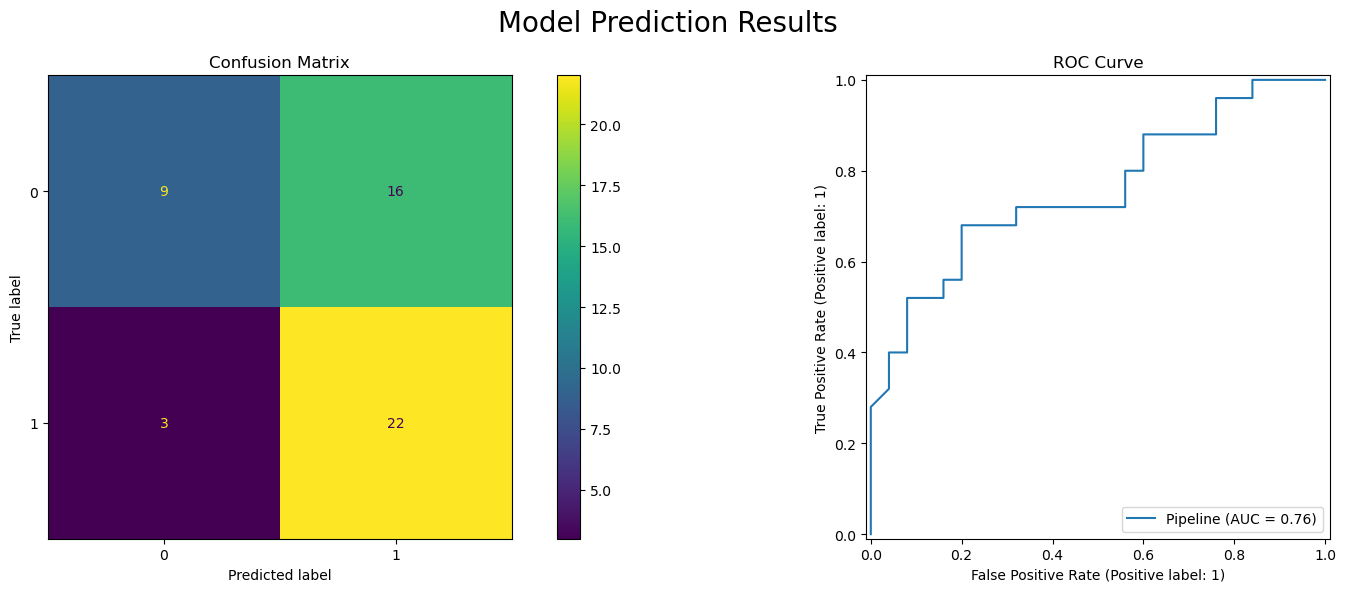

Importance
(6, 2)


,Feature,Importance
0,numeric__region_frontal_offset,0.202734
1,numeric__region_frontal_exponent,0.170827
5,numeric__region_posterior_exponent,0.163836
4,numeric__region_posterior_offset,0.160249
3,numeric__region_central_exponent,0.155924


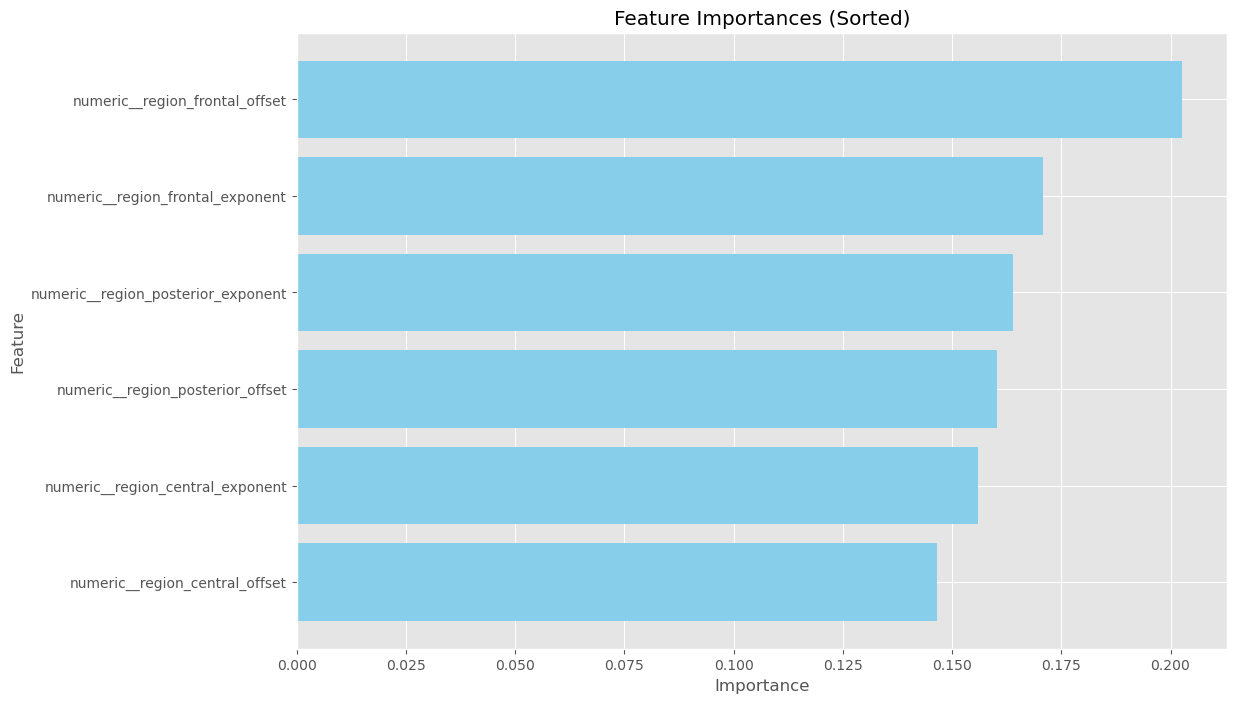

In [8]:
# Model Predictions

start_time = time.perf_counter()
y_pred = model_randforest.predict(X_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_randforest, X_transformed, y, y_pred)

# Feature Importance / Contribution
feature_importance(model_randforest, features_prep_pipeline)